In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
mnist = tf.keras.datasets.mnist
(x_train_matrix, y_train), (x_test_matrix, y_test) = mnist.load_data()

I dati sono in formato di matrice, ma noi lavoreremo con il vettore dei pixel, è quindi necessario prima appiattire tutte le matrici.

In [3]:
x_train = np.array([x_train_matrix[i].reshape(-1) for i in range(len(x_train_matrix))])
x_test = np.array([x_test_matrix[i].reshape(-1) for i in range(len(x_test_matrix))])

Convertire il tutto in pandas.DataFrame per visualizzare 

In [4]:
df_x = pd.DataFrame(x_train)
df_x['label'] = y_train
df_x.columns = [f'pixel_{i}' for i in range(784)] + ['label']
df_x.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


Unisco y_train e x_train per mischiare allo stesso modo i dati. Successivamente li divido in training e validation

In [5]:
y_train = y_train.reshape(-1,1)
data =  np.concatenate((y_train, x_train), axis=1)
np.random.shuffle(data)

data_val = data[0:10000].T
Y_val = data_val[0]
X_val = data_val[1:] / 255

data_train = data[10000:].T
Y_train = data_train[0]
X_train = data_train[1:] /255

In [6]:
X_test = x_test.T / 255
Y_test = y_test.T

Creiamo ora la funzione che verrà utilizzata per inizializzare i pesi e il bias della rete neurale

# Visual Representation of Neural Network

In [7]:
from draw_NN import DrawNN
from collections import deque

In [8]:
def ReLU(Z):
    # This will be applied to each element of Z
    return np.maximum(0, Z)

def softmax(Z):
    e_x = np.exp(Z - np.max(Z))
    return e_x / e_x.sum(axis=0)

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, int(Y.max() + 1)))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def deriv_ReLU(Z):
    return Z>0

def get_predictions(A):
    return np.argmax(A, 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

In [9]:
class NeuralNetwork:
    def __init__(self, layers, size_input = 784, size_output = 10, seed = 10 ):
        
        if len(layers) < 2:
            print(f'!! Insert at least TWO hidden layer in the neural network !!')
            layers = [10, 10]
            
        if layers[-1] != size_output:
            print(f'!! The size of the last layer has to be the same of the output ({size_output}) !!')
            layers[-1] = size_output
        
        self.layers = layers
        self.num_layers = len(layers)
        self.size_input = size_input
        self.size_output = size_output
        
        self.W, self.b = self.init_params(seed = seed)
    
    def init_params(self, seed):
        # W1 are size (num_perceptrons, num_previous_connection)
        W = []
        b = []
        np.random.seed(seed)
        W.append( np.random.rand(self.layers[0], self.size_input) - 0.5)
        b.append(np.random.rand(self.layers[0], 1) - 0.5)
        
        for i in range(self.num_layers - 1):
            W.append( np.random.rand(self.layers[i+1], self.layers[i]) - 0.5)
            b.append(np.random.rand(self.layers[i+1], 1) - 0.5)
        
        return W, b

    def prediction(self, X):
        
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        Z = self.W[0].dot(X) + self.b[0]
        
        for i in range(1,self.num_layers):
            A = ReLU(Z)
            if A.ndim == 1:
                A = A.reshape(-1, 1)
            Z = self.W[i].dot(A) + self.b[i]
        
        output = softmax(Z)
        
        return output

    def forward_prop(self, X):
        Z = []
        A = []
        
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        Z.append(self.W[0].dot(X) + self.b[0])
        
        for i in range(1,self.num_layers):
            A.append(ReLU(Z[-1]))
            if A[-1].ndim == 1:
                A[-1] = A[-1].reshape(-1, 1)
            Z.append(self.W[i].dot(A[-1]) + self.b[i])
        
        A.append(softmax(Z[-1]))
        
        return Z, A 
    
    def backward_prop(self, Z, A, X, Y):
        dW = deque()
        db = deque()
        m = Y.size
        one_hot_Y = one_hot(Y)
        
        dZ = A[-1] - one_hot_Y
        
        for i in range(2,self.num_layers+1):
            dW.appendleft(1 / m * dZ.dot(A[-i].T))
            db.appendleft((1/ m * dZ.sum(axis=1)).reshape(-1,1))
            dZ = self.W[-i + 1].T.dot(dZ) * deriv_ReLU(Z[-i])
            
        dW.appendleft(1 / m * dZ.dot(X.T))
        db.appendleft((1/ m * dZ.sum(axis=1)).reshape(-1,1))
        
        return list(dW), list(db)
    
    def update_param(self, dW, db, alpha = 0.1):
        
        for i in range(self.num_layers):            
            self.W[i]= self.W[i] - alpha * dW[i]
            self.b[i] = self.b[i] - alpha * db[i]
            
    def iterate(self, X, Y, alpha = 0.1):
        
        Z, A = self.forward_prop(X)
        dW, db = self.backward_prop(Z, A, X, Y)
        self.update_param(dW, db, alpha = alpha)
        
        return get_accuracy(get_predictions(A[-1]), Y)
        
    def training_gradient_descent(self, X, Y, X_val, Y_val, iterations = 100, alpha = 0.1):
        accuracy = []
        val_accuracy = []
        stop_warnings = 0
        
        W_final = self.W
        b_final = self.b
        final_version = 0
        for i in range(iterations):
            result = self.iterate(X, Y, alpha = alpha)
            
            accuracy.append(result)
            
            prediction = self.prediction(X_val)
            val_accuracy.append(get_accuracy(get_predictions(prediction), Y_val))
            
            if len(val_accuracy)>2 and val_accuracy[-1] < val_accuracy[-2]:
                stop_warnings +=1
            else:
                W_final = self.W
                b_final = self.b
                final_version = i
                stop_warnings = 0
                
            if stop_warnings >= 50:
                break
            
            if i % 200 == 0:
                print(f'Iteration {i}')
                print(f'Accuracy : {accuracy[-1]}')
        
        plt.plot(accuracy, color='r', label='Training Accuracy')
        plt.plot(val_accuracy, color='g', label='Validation Accuracy')
        plt.axvline(x = final_version, color = 'b', linestyle = '--')
        
        plt.xlabel("Iteration")
        plt.ylabel("Accuracy")
        plt.title("Training and Validation comparation")
        
        plt.legend()
        
        plt.show()
        
        print(f'Training finished in {i+1} iterations')       
        print(f'Final Accuracy : {accuracy[-1]}')   
        
        self.W = W_final
        self.b = b_final     
        
    def draw(self):
        network = DrawNN( [1] + self.layers + [1])
        network.draw()

Iteration 0
Accuracy : 0.09344
Iteration 200
Accuracy : 0.78832
Iteration 400
Accuracy : 0.8492


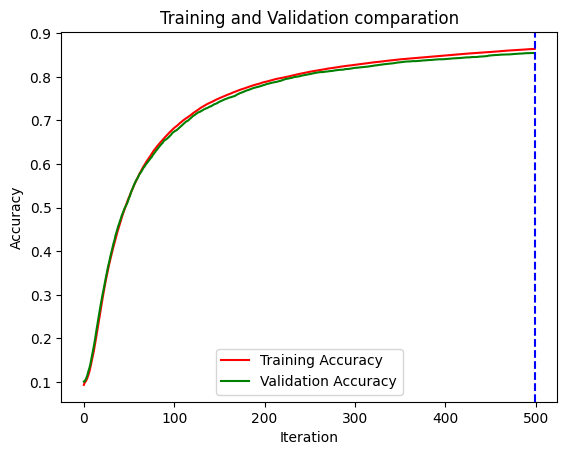

Training finished in 500 iterations
Final Accuracy : 0.86418


In [10]:
nn = NeuralNetwork([15,10], seed = 0)
nn.training_gradient_descent(X_train, Y_train, X_val, Y_val, iterations= 500)

In [11]:
def init_params(size_first_hl = 10):
    # W1 are size (num_perceptrons, num_previous_connection)
    np.random.seed(0)
    W1 = np.random.rand(size_first_hl, 784) - 0.5
    b1 = np.random.rand(size_first_hl, 1) - 0.5
    
    W2 = np.random.rand(10, size_first_hl) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    
    return W1, b1, W2, b2

In [12]:
def forward_prop(X, W1, b1, W2, b2):
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    
    if A1.ndim == 1:
        A1 = A1.reshape(-1, 1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    
    return Z1, A1, Z2, A2

In [13]:
def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    m = Y.size
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1/ m * dZ2.sum(axis=1)
    db2 = db2.reshape(-1,1)
    
    dZ1 = W2.T.dot(dZ2) * deriv_ReLU(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1/ m * dZ1.sum(axis=1)
    db1 = db1.reshape(-1,1)
    
    return dW1, dW2, db1, db2

In [14]:
def update_param(W1, b1, W2, b2, dW1, dW2, db1, db2, alpha = 0.5):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    
    return W1, b1, W2, b2

In [15]:
def gradient_descent(X, Y, X_val, Y_val, iterations = 1, alpha = 0.5, size_first_hl = 10):
    accuracy = []
    val_accuracy = []
    stop_warnings = 0
    
    W1, b1, W2, b2 = init_params(size_first_hl = size_first_hl)
    W1_final = W1
    b1_final = b1
    W2_final = W2
    b2_final = b2
    final_version = 0
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(X, W1, b1, W2, b2)
        dW1, dW2, db1, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_param(W1, b1, W2, b2, dW1, dW2, db1, db2, alpha = alpha)
        
        accuracy.append(get_accuracy(get_predictions(A2), Y))
        
        Z1_val, A1_val, Z2_val, A2_val = forward_prop(X_val, W1, b1, W2, b2)
        val_accuracy.append(get_accuracy(get_predictions(A2_val), Y_val))
        
        if len(val_accuracy)>2 and val_accuracy[-1] < val_accuracy[-2]:
            stop_warnings +=1
        else:
            W1_final = W1
            b1_final = b1
            W2_final = W2
            b2_final = b2
            final_version = i
            stop_warnings = 0
            
        if stop_warnings >= 50:
            break
        
        if i % 200 == 0:
            print(f'Iteration {i}')
            print(f'Accuracy : {accuracy[-1]}')
    
    plt.plot(accuracy, color='r', label='Training Accuracy')
    plt.plot(val_accuracy, color='g', label='Validation Accuracy')
    plt.axvline(x = final_version, color = 'b', linestyle = '--')
    
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation comparation")
    
    plt.legend()
    
    plt.show()
    
    print(f'Training finished in {i+1} iterations')       
    print(f'Final Accuracy : {accuracy[-1]}')        
    
    return W1_final, b1_final, W2_final, b2_final

In [16]:
W1, b1, W2, b2 = init_params(size_first_hl = 15)

In [ ]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, X_val, Y_val,iterations = 500, alpha = 0.1, size_first_hl = 15)

Iteration 0
Accuracy : 0.09344


## Testing

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


In [ ]:
Z1, A1, Z2, A2 = forward_prop(X_test, W1, b1, W2, b2)
predicted = get_predictions(A2)
print(f'Accuracy : {get_accuracy(predicted, Y_test)}')

Accuracy : 0.9395


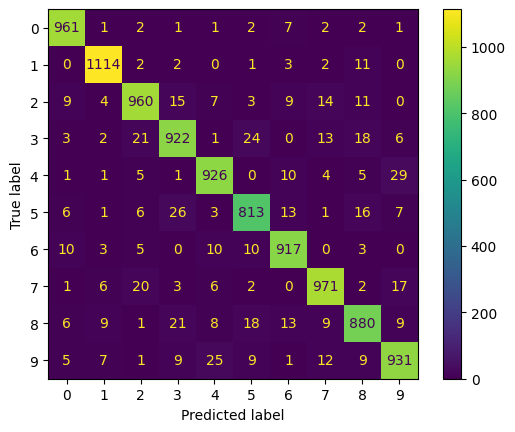

In [ ]:
conf_matrix = confusion_matrix(Y_test, predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
cm_display.plot()
plt.show()

## Show results

In [ ]:
def show_results(W1, b1, W2, b2, X_test, i = -1):
    if i <0 or i>len(X_test):
        i = int(np.random.uniform( low = 0.0, high = len(X_test)))
    Z1, A1, Z2, A2 = forward_prop(X_test[:,i], W1, b1, W2, b2)
    plt.imshow(x_test_matrix[i], cmap='Greys',  interpolation='nearest')
    plt.suptitle(f'Real value: {y_test[i]}')
    plt.title(f'Predicted value: {np.argmax(A2)}')

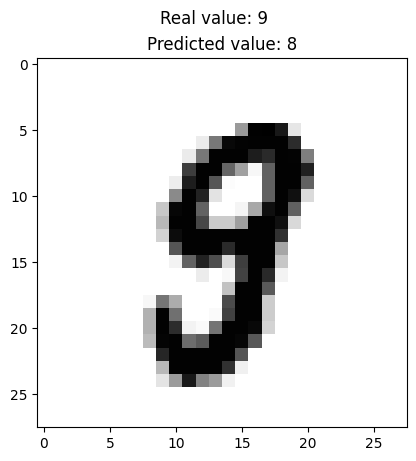

In [ ]:
show_results(W1, b1, W2, b2, X_test)

Next steps: 
- fare in modo che la rete neurale sia modificabile anche in lunghezza